# Customers Segmentation

In [1]:
import numpy as np
import pandas as pd


import gc
import os

# matplotlib and seaborn for plotting
import matplotlib
matplotlib.rcParams['figure.dpi'] = 120 #resolution
matplotlib.rcParams['figure.figsize'] = (8,6) #figure size

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
color = sns.color_palette()

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

from sklearn.decomposition import PCA

root = "C:/Users/HP/Downloads/market"

## Data

In [2]:
aisles = pd.read_csv(root + '/aisles.csv')
departments = pd.read_csv(root + '/departments.csv')
orders = pd.read_csv(root + '/orders.csv')
order_products_prior = pd.read_csv(root + '/order_products__prior.csv')
order_products_train = pd.read_csv(root + '/order_products__train.csv')
products = pd.read_csv(root + '/products.csv')

For segmentation I am considering users from prior set only

In [3]:
order_products = order_products_prior.merge(products, on ='product_id', how='left')
order_products = order_products.merge(aisles, on ='aisle_id', how='left')
order_products = order_products.merge(departments, on ='department_id', how='left')
order_products = order_products.merge(orders, on='order_id', how='left')
order_products.shape

(32434489, 15)

In [4]:
order_products.head()

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,aisle,department,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2,33120,1,1,Organic Egg Whites,86,16,eggs,dairy eggs,202279,prior,3,5,9,8.0
1,2,28985,2,1,Michigan Organic Kale,83,4,fresh vegetables,produce,202279,prior,3,5,9,8.0
2,2,9327,3,0,Garlic Powder,104,13,spices seasonings,pantry,202279,prior,3,5,9,8.0
3,2,45918,4,1,Coconut Butter,19,13,oils vinegars,pantry,202279,prior,3,5,9,8.0
4,2,30035,5,0,Natural Sweetener,17,13,baking ingredients,pantry,202279,prior,3,5,9,8.0


In [5]:
order_products.user_id.nunique()

206209

In [7]:
order_products.columns

Index(['order_id', 'product_id', 'add_to_cart_order', 'reordered',
       'product_name', 'aisle_id', 'department_id', 'aisle', 'department',
       'user_id', 'eval_set', 'order_number', 'order_dow', 'order_hour_of_day',
       'days_since_prior_order'],
      dtype='object')

## Segmentation

Since there are thousands of products in the dataset I will rely on aisles, which represent categories of products. Even with aisles features will be too much so I will use Principal Component Analysis to find new dimensions along which clustering will be easier.

In [8]:
cross_df = pd.crosstab(order_products.user_id, order_products.aisle)
cross_df.head()

aisle,air fresheners candles,asian foods,baby accessories,baby bath body care,baby food formula,bakery desserts,baking ingredients,baking supplies decor,beauty,beers coolers,...,spreads,tea,tofu meat alternatives,tortillas flat bread,trail mix snack mix,trash bags liners,vitamins supplements,water seltzer sparkling water,white wines,yogurt
user_id,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
2,0,3,0,0,0,0,2,0,0,0,...,3,1,1,0,0,0,0,2,0,42
3,0,0,0,0,0,0,0,0,0,0,...,4,1,0,0,0,0,0,2,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0
5,0,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3


In [9]:
cross_df.tail()

aisle,air fresheners candles,asian foods,baby accessories,baby bath body care,baby food formula,bakery desserts,baking ingredients,baking supplies decor,beauty,beers coolers,...,spreads,tea,tofu meat alternatives,tortillas flat bread,trail mix snack mix,trash bags liners,vitamins supplements,water seltzer sparkling water,white wines,yogurt
user_id,,,,,,,,,,,,,,,,,,,,,
206205,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,5
206206,0,4,0,0,0,0,4,1,0,0,...,1,0,0,0,0,1,0,1,0,0
206207,0,0,0,0,1,0,0,0,0,0,...,3,4,0,2,1,0,0,11,0,15
206208,0,3,0,0,3,0,4,0,0,0,...,5,0,0,7,0,0,0,0,0,33
206209,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,3


I will normalize each row

In [11]:
df = cross_df.div(cross_df.sum(axis=1), axis=0)
df.head()

aisle,air fresheners candles,asian foods,baby accessories,baby bath body care,baby food formula,bakery desserts,baking ingredients,baking supplies decor,beauty,beers coolers,...,spreads,tea,tofu meat alternatives,tortillas flat bread,trail mix snack mix,trash bags liners,vitamins supplements,water seltzer sparkling water,white wines,yogurt
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.016949,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.016949
2,0.0,0.015385,0.0,0.0,0.0,0.0,0.010256,0.0,0.0,0.0,...,0.015385,0.005128,0.005128,0.000000,0.0,0.0,0.0,0.010256,0.0,0.215385
3,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.045455,0.011364,0.000000,0.000000,0.0,0.0,0.0,0.022727,0.0,0.000000
4,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.055556,0.0,0.0,0.0,0.055556,0.0,0.000000
5,0.0,0.054054,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.081081


In [12]:
df.shape

(206209, 134)

### PCA and K-Means Clustering

Reducing this dataframe to only 10 dimensions as KMeans does not work properly in higher dimension. 

In [13]:
pca = PCA(n_components=10)
df_pca = pca.fit_transform(df)
df_pca = pd.DataFrame(df_pca)
df_pca.head()

,0,1,2,3,4,5,6,7,8,9
0,-0.113443,0.039084,-0.042863,0.018866,-0.088350,-0.104555,-0.116431,0.083877,-0.062748,-0.027367
1,-0.036988,0.108884,-0.066406,-0.123270,0.098852,-0.033973,-0.054735,-0.053394,-0.020372,-0.008333
2,0.064282,0.103962,0.000710,-0.012219,-0.046978,0.112210,-0.029804,0.007829,0.011777,0.000920
3,-0.093210,0.054093,0.001867,-0.003974,-0.071356,-0.019262,-0.025104,-0.038291,0.007040,0.000149
4,0.094629,-0.037051,-0.024952,-0.021574,0.055371,0.107643,-0.008031,0.103917,0.051753,-0.025774


In [14]:
Sum_of_squared_distances = []
K = range(1,10)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(df_pca)
    Sum_of_squared_distances.append(km.inertia_)

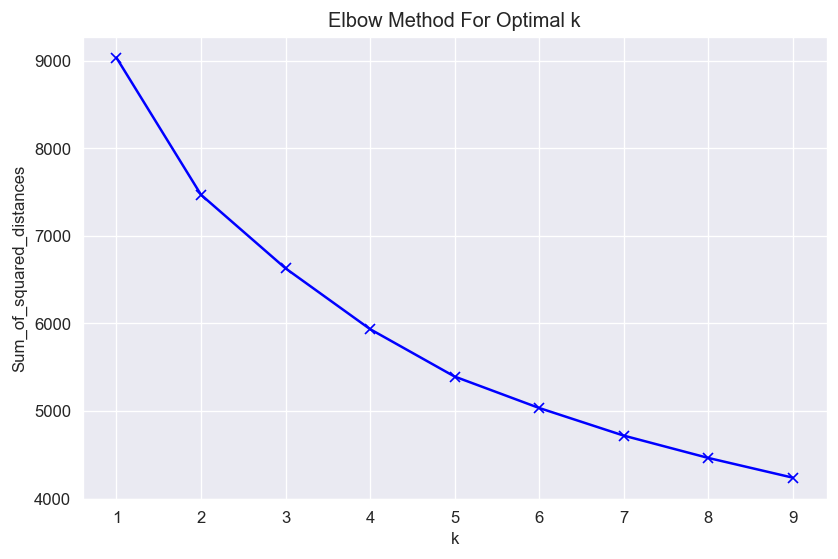

In [15]:
plt.subplots(figsize = (8, 5))
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

From above plot we can choose optimal K as 5

In [16]:
clusterer = KMeans(n_clusters=5,random_state=42).fit(df_pca)
centers = clusterer.cluster_centers_
c_preds = clusterer.predict(df_pca)
print(centers)

[[-1.98274645e-01  1.61778113e-02  3.17235428e-01 -3.14083367e-02
   1.87336033e-02  6.19683878e-04  4.05974965e-03  1.08896382e-02
   1.17428370e-03 -3.83126444e-03]
 [ 6.76280451e-02  1.05962997e-01 -1.10851395e-03 -3.09424479e-02
  -1.07611561e-02  7.18208093e-03 -5.22549674e-04  4.51140500e-03
  -7.00249957e-04 -1.57189675e-04]
 [-7.38903001e-02 -1.05628811e-02 -2.70090678e-02 -7.01041656e-03
  -6.74815743e-03  1.55029496e-03  5.03482389e-04 -2.52868324e-03
  -3.20192757e-04 -4.07140334e-04]
 [ 1.05524236e-01 -7.30532109e-02  1.72439726e-02  3.66720436e-03
   1.76642791e-03 -4.42367480e-03 -9.45395713e-04  1.29797704e-03
  -1.85773865e-04  7.55904232e-04]
 [-6.13750780e-03  1.30694670e-01  4.86938900e-03  2.30160534e-01
   1.10162231e-01 -2.28040982e-02  8.05928578e-05 -6.43537445e-03
   7.82906086e-03  3.12432000e-03]]


#### Visualizing clustering among first two principal components

In [17]:
temp_df = df_pca.iloc[:, 0:2]
temp_df.columns = ["pc1", "pc2"]
temp_df['cluster'] = c_preds
temp_df.head()

C:\Users\HP\AppData\Local\Temp\ipykernel_19552\1558269435.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df['cluster'] = c_preds


,pc1,pc2,cluster
0,-0.113443,0.039084,2
1,-0.036988,0.108884,1
2,0.064282,0.103962,1
3,-0.093210,0.054093,2
4,0.094629,-0.037051,3


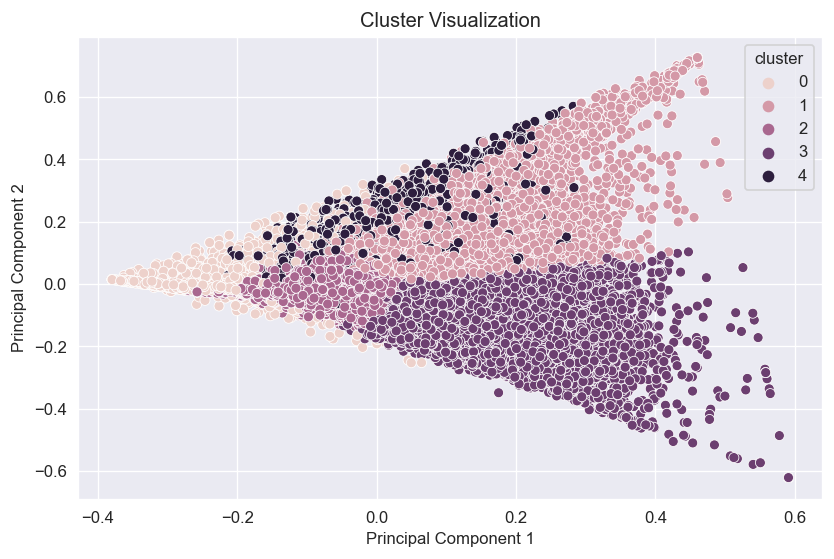

In [18]:
fig, ax = plt.subplots(figsize = (8, 5))
ax = sns.scatterplot(data = temp_df, x = "pc1", y = "pc2", hue = "cluster")
ax.set_xlabel("Principal Component 1")
ax.set_ylabel("Principal Component 2")
ax.set_title("Cluster Visualization")
plt.show();

### Top products per cluster

In [19]:
cross_df['cluster'] = c_preds

cluster1 = cross_df[cross_df.cluster == 0]
cluster2 = cross_df[cross_df.cluster == 1]
cluster3 = cross_df[cross_df.cluster == 2]
cluster4 = cross_df[cross_df.cluster == 3]
cluster5 = cross_df[cross_df.cluster == 4]

In [20]:
cluster1.shape

(5414, 135)

In [21]:
cluster1.drop('cluster',axis=1).mean().sort_values(ascending=False)[0:10]

aisle
water seltzer sparkling water    20.950683
fresh fruits                      3.336535
soft drinks                       2.800702
yogurt                            2.254895
energy granola bars               1.557074
chips pretzels                    1.346694
milk                              1.327484
tea                               1.327115
packaged vegetables fruits        1.251201
soy lactosefree                   1.082564
dtype: float64

In [22]:
cluster2.shape

(37849, 135)

In [23]:
cluster2.drop('cluster',axis=1).mean().sort_values(ascending=False)[0:10]

aisle
fresh fruits                     35.759492
fresh vegetables                 15.027319
packaged vegetables fruits       12.096040
yogurt                            9.877830
milk                              5.956168
packaged cheese                   5.111522
soy lactosefree                   3.776507
water seltzer sparkling water     3.613490
bread                             3.196148
chips pretzels                    3.129330
dtype: float64

In [24]:
cluster3.shape

(99149, 135)

In [25]:
cluster3.drop('cluster',axis=1).mean().sort_values(ascending=False)[0:10]

aisle
fresh fruits                     9.777708
fresh vegetables                 7.575215
yogurt                           7.225489
packaged vegetables fruits       6.002824
packaged cheese                  4.931638
chips pretzels                   4.482698
milk                             4.255363
water seltzer sparkling water    4.091610
refrigerated                     3.257259
ice cream ice                    3.098468
dtype: float64

In [26]:
cluster4.shape

(55849, 135)

In [27]:
cluster4.drop('cluster',axis=1).mean().sort_values(ascending=False)[0:10]

aisle
fresh vegetables                 37.034486
fresh fruits                     21.751347
packaged vegetables fruits       12.029311
yogurt                            6.161919
packaged cheese                   5.020269
fresh herbs                       4.150334
milk                              4.004423
soy lactosefree                   3.705742
frozen produce                    3.302870
water seltzer sparkling water     3.080288
dtype: float64

In [28]:
cluster5.shape

(7948, 135)

In [29]:
cluster5.drop('cluster',axis=1).mean().sort_values(ascending=False)[0:10]

aisle
packaged produce                 18.356442
fresh fruits                     10.873427
packaged vegetables fruits        4.242199
fresh vegetables                  3.108455
water seltzer sparkling water     1.714771
milk                              1.614872
packaged cheese                   1.548691
frozen produce                    1.144942
chips pretzels                    1.139280
nuts seeds dried fruit            1.033090
dtype: float64

Customer Segmentation Results:

- Cluster 1 results into 5428 consumers having a very strong preference for water seltzer sparkling water aisle.
- Cluster 2 results into 55784 consumers who mostly order fresh vegetables followed by fruits.
- Cluster 3 results into 7948 consumers who buy packaged produce and fresh fruits mostly.
- Cluster 4 results into 37949 consumers who have a very strong preference for fruits followed by fresh vegetables.
- Cluster 5 results into 99100 consumers who orders products from many aisles. Their mean orders are low compared to other clusters which tells us that either they are not frequent users of Instacart or they are new users and do not have many orders yet. 